In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deep_gravity_utils as dgu
import scipy.linalg as scilinalg
import ipdb

In [2]:
dgu.setup_seed(12)

## Reading data (daily)

In [3]:
config = pd.read_csv('config.csv')
year = config.loc[0, 'year']
year=2020
OD = np.load('./data/3d_%i_30days.npy'%year)[:48, :48]

adj_mat = pd.read_csv('./data/connectivity.csv', index_col=0).iloc[:48, :48].to_numpy()
stops = pd.read_csv('./data/stops_order.csv', index_col=0).iloc[:48, :]
stations = list(stops['stop'])

print('Shape of OD:', OD.shape)
print('Year', year)


Shape of OD: (48, 48, 720)
Year 2020


In [4]:
A_mode = adj_mat+np.eye(adj_mat.shape[0])
D_mode = np.zeros_like(A_mode)
np.fill_diagonal(D_mode, A_mode.sum(axis=1))
D_mode_inv_root = np.linalg.inv(scilinalg.sqrtm(D_mode))
A_mode = D_mode_inv_root @ A_mode @ D_mode_inv_root

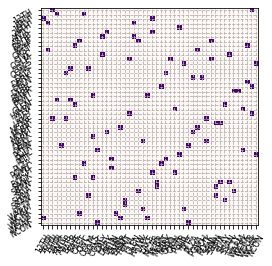

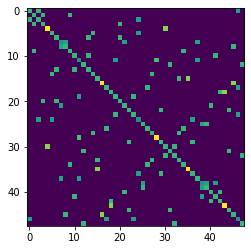

In [5]:
# plt.figure(figsize=[8,8], dpi=75)
plt.imshow(adj_mat, cmap='RdPu')
plt.xticks(range(48), stations, rotation=60, fontsize=8)
plt.yticks(range(48), stations, rotation=30, fontsize=8)
plt.grid(ls='--')
plt.figure()
plt.imshow(A_mode)

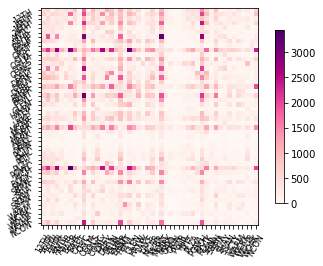

In [6]:
plt.figure()
plt.imshow(OD.sum(axis=2), cmap='RdPu')
plt.xticks(range(48), stations, rotation=60, fontsize=8)
plt.yticks(range(48), stations, rotation=30, fontsize=8)
plt.colorbar(shrink=0.8)

In [7]:
t_past = config.loc[0, 't_past']
t_future = config.loc[0, 't_pre']
OD_4d = dgu.const_4d_OD(OD, t_past, t_future)


Memory occupied 113.9062 MB


In [8]:
OD_4d = np.transpose(OD_4d, (0, 2, 3, 1))

In [9]:
# daily ridership data
print(OD_4d.shape)
print(adj_mat.shape)
print(stops.shape)

(711, 48, 48, 9)
(48, 48)
(48, 1)


# Gravity Model Inspired Neural Network (FC)

In [10]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [11]:
# Model specification
class GraphRidershipNet(nn.Module):
    def __init__(self, adj_mat, t_past, t_future, dropout_p=0.0):
        super(GraphRidershipNet, self).__init__()
        
        self.adj_mat = adj_mat
        self.inp_size = t_past*48
        self.out_size = t_future*48
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=self.inp_size, out_features=32*48),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(in_features=32*48, out_features=32*48),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(in_features=32*48, out_features=16*48),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(in_features=16*48, out_features=16*48),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(in_features=16*48, out_features=self.out_size)
        )
        
        
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        x = torch.matmul(self.adj_mat, x)
        x = self.fc(x)

        return x
    

## Train the model

In [12]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop = config.loc[0, 'prop']
l = int(OD_4d.shape[0]*prop)

X_train = OD_4d[:l, :, :, :t_past]
y_train = OD_4d[:l, :, :, t_past:]
X_val = OD_4d[l:, :, :, :t_past]
y_val = OD_4d[l:, :, :, t_past:]

# X_train = np.transpose(X_train, (3, 1, 2, 0)).reshape(t_past, -1).T
# y_train = np.transpose(y_train, (3, 1, 2, 0)).reshape(t_future, -1).T
# X_val = np.transpose(X_val, (3, 1, 2, 0)).reshape(t_past, -1).T
# y_val = np.transpose(y_val, (3, 1, 2, 0)).reshape(t_future, -1).T

X_train = X_train.reshape(l, 48, -1)
y_train = y_train.reshape(l, 48, -1)
X_val = X_val.reshape((OD_4d.shape[0]-l), 48, -1)
y_val = y_val.reshape((OD_4d.shape[0]-l), 48, -1)


In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
adj_mat = torch.tensor(adj_mat, dtype=torch.float32).to(device)
A_mode = torch.tensor(A_mode, dtype=torch.float32).to(device)

batch_size = 2**9
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)
print(batch_size)

512


In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([497, 48, 240])
torch.Size([497, 48, 192])
torch.Size([214, 48, 240])
torch.Size([214, 48, 192])


In [15]:
# Train the model by inputing 
# [land use data and trip data (demand at each region)] 
# to the model, then output one column of OD

model = GraphRidershipNet(A_mode, t_past, t_future).to(device)
loss_func = nn.MSELoss()
loss_set_train = []
loss_set_val = []
hid_set = []


In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
# summary(model, [300,inp_ch_size,48,48])

In [18]:
model.train()

epochs = 500

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs+1):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if e%50==0:
        out_val = model(X_val)
        loss_val = loss_func(out_val, y_val)
        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:1.432722, train loss:1.848433
Epoch 50   success, val loss:0.888897, train loss:1.074868
Epoch 100   success, val loss:0.909938, train loss:0.756401
Epoch 150   success, val loss:0.797795, train loss:0.635920
Epoch 200   success, val loss:0.781566, train loss:0.581244
Epoch 250   success, val loss:0.778741, train loss:0.543994
Epoch 300   success, val loss:0.778223, train loss:0.524685
Epoch 350   success, val loss:0.776655, train loss:0.507762
Epoch 400   success, val loss:0.765552, train loss:0.496376
Epoch 450   success, val loss:0.752470, train loss:0.485660
Epoch 500   success, val loss:0.778597, train loss:0.469777


In [19]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Epoches/50')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Epoches/50')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    plt.suptitle(title)

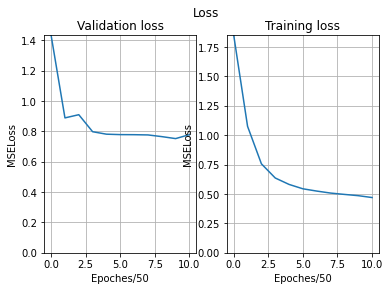

In [20]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

In [21]:
out_val.shape

torch.Size([214, 48, 192])

(493056, 4)
The mae loss is 0.4301
The mape loss is 0.6060
The smape loss is 1.7761
The nrmse loss is 0.0090
The nmae loss is 0.0041


C:\Users\10169\Documents\Github\Deep_Gravity\deep_gravity_utils.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))


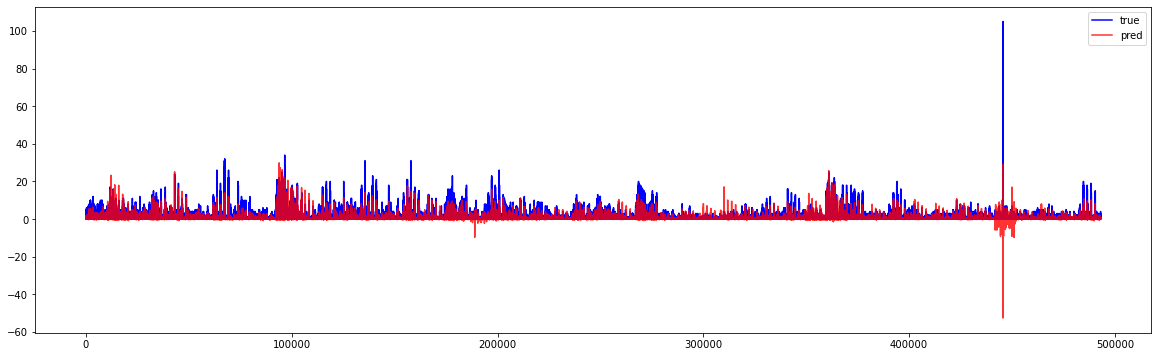

In [22]:
h = t_future-1
pred_ = out_val.cpu().detach().numpy()
pred_ = pred_.reshape(pred_.shape[0], 48, 48, -1)
pred = np.transpose(pred_, (3, 1, 2, 0)).reshape(t_future, -1).T
np.save('./res/%.1f/convgraph2_%i.npy'%(prop, year), pred)
labels_ = y_val.cpu().detach().numpy()
labels_ = labels_.reshape(labels_.shape[0], 48, 48, -1)
labels = np.transpose(labels_, (3, 1, 2, 0)).reshape(t_future, -1).T
print(pred.shape)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))

plt.figure(figsize=[20, 6])
plt.plot(labels[:, h], '-', label='true', c='b')
plt.plot(pred[:, h], '-', label='pred', c='r', alpha=0.8)
plt.legend()

The mae loss is 23.7191
The mape loss is 1.4108
The smape loss is 0.5521
The nrmse loss is 0.0379
The nmae loss is 0.0239


C:\Users\10169\Documents\Github\Deep_Gravity\deep_gravity_utils.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))


Text(0.5, 1.0, 'Real OD')

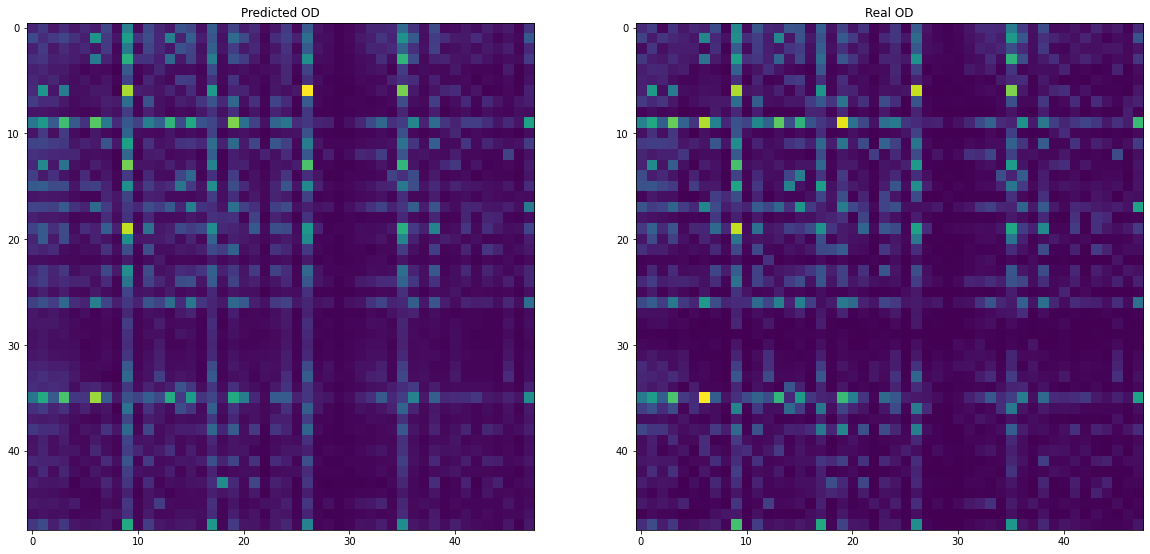

In [23]:
pred = pred_.sum(axis=0)
labels = labels_.sum(axis=0)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))

fig = plt.figure(figsize=[20,10])

ax1 = fig.add_subplot(121)
ax1.imshow(pred[:,:, 0])
ax1.set_title('Predicted OD')

ax2 = fig.add_subplot(122)
ax2.imshow(labels[:,:, 0])
ax2.set_title('Real OD')

In [24]:
print('CPC is %.5f'%dgu.get_CPC(pred, labels))

CPC is 0.85053


In [25]:
# torch.save(model.to('cpu').state_dict(), './models/model_48stations_graph.pth')

# Visualization of trips on map

In [26]:
import geopandas as gpd

In [27]:
data_X_all = gpd.read_file('./data/data_X_all.shp')

In [28]:
data_X_all.head(2)

,GEOID,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,...,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID,if_keep,nearest st,transit di,geometry
0,06001983200,37.804224,-122.27715,11084.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",1664.0,2208.0,...,71.028333,707.012491,1891149.0,1455141.0,16.972222,06001,1.0,12TH,0.895287,"POLYGON ((-122.28374 37.79480, -122.28343 37.7..."
1,06075020500,37.769279,-122.43602,142973.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",20505.0,29075.0,...,30.318892,697.115918,16339411.0,11103193.0,16.600806,06075,1.0,16TH,2.424009,"POLYGON ((-122.43467 37.75611, -122.43564 37.7..."


In [29]:
bart_coor = pd.read_csv('./data/station-coor.csv', index_col=0)
bart_coor.head(2)

,abbr,lat,lon
0,12TH,37.803768,-122.271450
1,16TH,37.765062,-122.419694


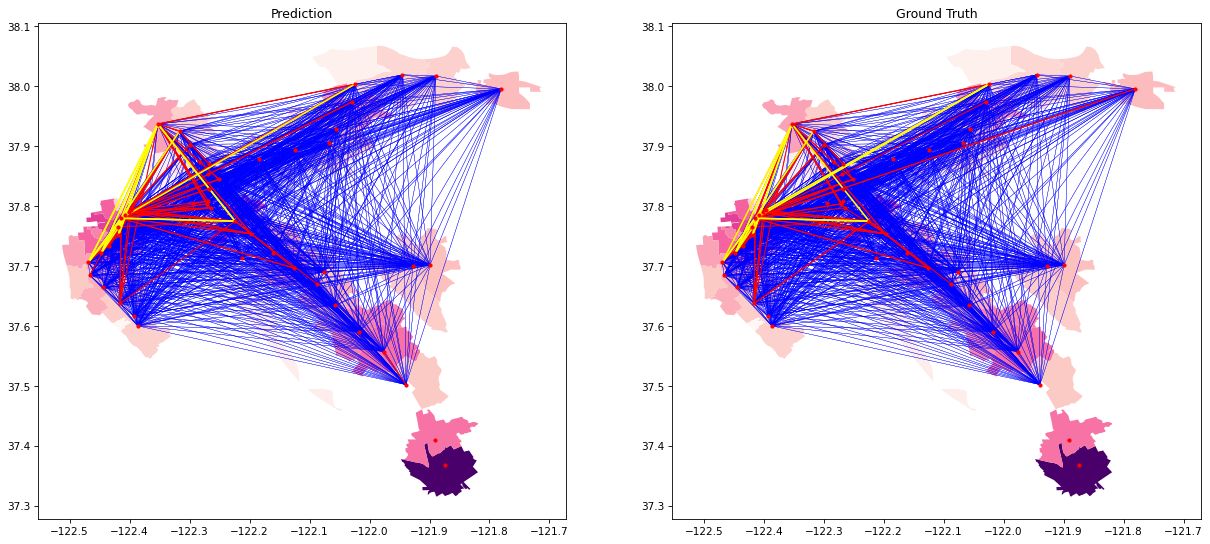

In [30]:
pred = out_val.cpu().detach().numpy().reshape(out_val.shape[0], 48, 48, -1).sum(axis=0)[:, :, 0]
labels = y_val.cpu().detach().numpy().reshape(y_val.shape[0], 48, 48, -1).sum(axis=0)[:, :, 0]

fig = plt.figure(figsize=[20, 10], dpi=75)
ax0 = fig.add_subplot(121)
ax0.set_title('Prediction')
ax1 = fig.add_subplot(122)
ax1.set_title('Ground Truth')

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
data_X_all.plot(column='TotPop', ax=ax1, cmap='RdPu')

# plot trips
num_pred_stations = pred.shape[0] // 50  # 50 means that there are 50 stations in total
pred_stations = stops.iloc[-num_pred_stations:, 0]

low_lon_pred_dest = []
low_lat_pred_dest = []
mid_lon_pred_dest = []
mid_lat_pred_dest = []
high_lon_pred_dest = []
high_lat_pred_dest = []
low_lon_pred_origin = []
low_lat_pred_origin = []
mid_lon_pred_origin = []
mid_lat_pred_origin = []
high_lon_pred_origin = []
high_lat_pred_origin = []

low_lon_labels_dest = []
low_lat_labels_dest = []
mid_lon_labels_dest = []
mid_lat_labels_dest = []
high_lon_labels_dest = []
high_lat_labels_dest = []
low_lon_labels_origin = []
low_lat_labels_origin = []
mid_lon_labels_origin = []
mid_lat_labels_origin = []
high_lon_labels_origin = []
high_lat_labels_origin = []

for i in pred_stations.index:
    station_dest = pred_stations.loc[i]
    for j in stops.index:
        station_origin = stops.loc[j, 'stop']
        
        lon_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lon'].values[0]
        lat_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lat'].values[0]
        lon_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lon'].values[0]
        lat_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lat'].values[0]
        
        dest_ind = i
        origin_ind = j
        
        if pred[origin_ind, dest_ind]-pred.min()<(pred.max()-pred.min())*0.3:
            low_lon_pred_dest.append(lon_dest)
            low_lat_pred_dest.append(lat_dest)
            low_lon_pred_origin.append(lon_origin)
            low_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif pred[origin_ind, dest_ind]-pred.min()>=(pred.max()-pred.min())*0.3 and pred[origin_ind, dest_ind]-pred.min()<(pred.max()-pred.min())*0.6:
            mid_lon_pred_dest.append(lon_dest)
            mid_lat_pred_dest.append(lat_dest)
            mid_lon_pred_origin.append(lon_origin)
            mid_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif pred[origin_ind, dest_ind]-pred.min()>=(pred.max()-pred.min())*0.6:
            high_lon_pred_dest.append(lon_dest)
            high_lat_pred_dest.append(lat_dest)
            high_lon_pred_origin.append(lon_origin)
            high_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)
        
        if labels[origin_ind, dest_ind]-labels.min()<(labels.max()-labels.min())*0.3:
            low_lon_labels_dest.append(lon_dest)
            low_lat_labels_dest.append(lat_dest)
            low_lon_labels_origin.append(lon_origin)
            low_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif labels[origin_ind, dest_ind]-labels.min()>=(labels.max()-labels.min())*0.3 and labels[origin_ind, dest_ind]-labels.min()<(labels.max()-labels.min())*0.6:
            mid_lon_labels_dest.append(lon_dest)
            mid_lat_labels_dest.append(lat_dest)
            mid_lon_labels_origin.append(lon_origin)
            mid_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif labels[origin_ind, dest_ind]-labels.min()>=(labels.max()-labels.min())*0.6:
            high_lon_labels_dest.append(lon_dest)
            high_lat_labels_dest.append(lat_dest)
            high_lon_labels_origin.append(lon_origin)
            high_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)

for i in range(len(low_lon_pred_dest)):
    ax0.plot([low_lon_pred_origin[i], low_lon_pred_dest[i]], [low_lat_pred_origin[i], low_lat_pred_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_pred_dest)):
    ax0.plot([mid_lon_pred_origin[i], mid_lon_pred_dest[i]], [mid_lat_pred_origin[i], mid_lat_pred_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_pred_dest)):
    ax0.plot([high_lon_pred_origin[i], high_lon_pred_dest[i]], [high_lat_pred_origin[i], high_lat_pred_dest[i]], 'yellow', lw=1.5)

for i in range(len(low_lon_labels_dest)):
    ax1.plot([low_lon_labels_origin[i], low_lon_labels_dest[i]], [low_lat_labels_origin[i], low_lat_labels_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_labels_dest)):
    ax1.plot([mid_lon_labels_origin[i], mid_lon_labels_dest[i]], [mid_lat_labels_origin[i], mid_lat_labels_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_labels_dest)):
    ax1.plot([high_lon_labels_origin[i], high_lon_labels_dest[i]], [high_lat_labels_origin[i], high_lat_labels_dest[i]], 'yellow', lw=1.5)



# plot stations
for i in bart_coor.index:
    lon = bart_coor.loc[i, 'lon']
    lat = bart_coor.loc[i, 'lat']
    ax0.plot(lon, lat, 'r.')
    ax1.plot(lon, lat, 'r.')

fig.savefig('./res/%.1f/convgraph2_%i_1.png'%(prop, year), dpi=700)

In [31]:
def get_straight_data(data):
    shape = data.shape
#     data = np.exp(-((data - data.min()) / (data.max() - data.min())).flatten())**30
    data = (data - data.min()) / (data.max() - data.min())
    return data.reshape(shape)


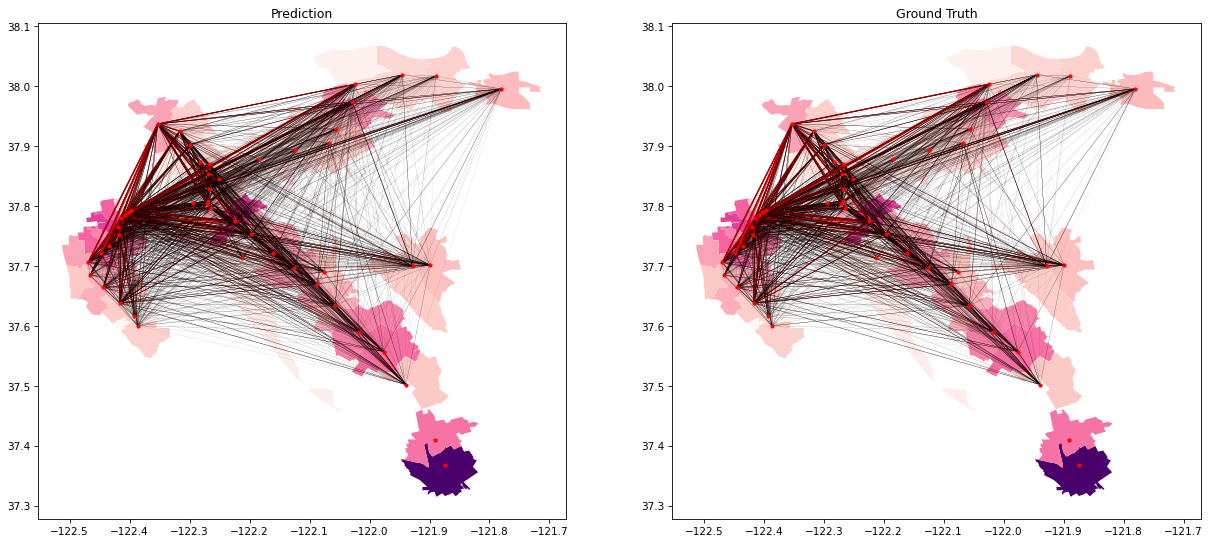

In [32]:
pred = out_val.cpu().detach().numpy().reshape(out_val.shape[0], 48, 48, -1).sum(axis=0)[:, :, 0]
pred_plot = get_straight_data(pred)
labels = y_val.cpu().detach().numpy().reshape(y_val.shape[0], 48, 48, -1).sum(axis=0)[:, :, 0]
labels_plot = get_straight_data(labels)

fig = plt.figure(figsize=[20, 10], dpi=75)
ax0 = fig.add_subplot(121)
ax0.set_title('Prediction')
ax1 = fig.add_subplot(122)
ax1.set_title('Ground Truth')

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
data_X_all.plot(column='TotPop', ax=ax1, cmap='RdPu')

# plot trips
num_pred_stations = pred.shape[0] // 50  # 50 means that there are 50 stations in total
pred_stations = stops.iloc[-num_pred_stations:, 0]

for i in pred_stations.index:
    station_dest = pred_stations.loc[i]
    for j in stops.index:
#         ipdb.set_trace()
        station_origin = stops.loc[j, 'stop']
        
        lon_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lon'].values[0]
        lat_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lat'].values[0]
        lon_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lon'].values[0]
        lat_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lat'].values[0]
        
        trip_pred = pred_plot[i, j]
        trip_label = labels_plot[i, j]
        
        c = min(trip_pred, 1)
        ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], lw=trip_pred*2, color=[c, 0, 0])
        
        c = min(trip_label, 1)
        ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], lw=trip_label*2, color=[c, 0, 0])



# plot stations
for i in bart_coor.index:
    lon = bart_coor.loc[i, 'lon']
    lat = bart_coor.loc[i, 'lat']
    ax0.plot(lon, lat, 'r.')
    ax1.plot(lon, lat, 'r.')

fig.savefig('./res/%.1f/convgraph2_%i_2.png'%(prop, year), dpi=700)